In [ ]:
# run this cell if you don't have dataset files
!wget -O data.zip https://repod.icm.edu.pl/api/datasets/251/versions/59/files/download?format=original
!unzip data.zip -d data

--2024-07-29 14:32:39--  https://repod.icm.edu.pl/api/datasets/251/versions/59/files/download?format=original
Resolving repod.icm.edu.pl (repod.icm.edu.pl)... 213.135.60.199
Connecting to repod.icm.edu.pl (repod.icm.edu.pl)|213.135.60.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘data.zip’

data.zip                [         <=>        ]  54.62M  4.50MB/s               

In [ ]:
# install mne and tensorflow libraries
!pip install mne tensorflow

# Necessary Imports

from glob import glob # Read files from folder
import os # Operating System interfaces

import mne # Analyze EEG data

import numpy as np # Calculations
import pandas as pd # Dataframes

import matplotlib.pyplot as plt # Plotting and Visualizations

from scipy import stats # statistical calculations - scientific data

from sklearn.linear_model import LogisticRegression # Logistic Regression for Features array
from sklearn.pipeline import Pipeline # Use a pipeline of our scaling for classification purpose
from sklearn.preprocessing import StandardScaler # Use standar scaler for classification preprocessing
from sklearn.model_selection import GroupKFold # Use KFold for groups(control vs schizophrenic)
from sklearn.model_selection import GridSearchCV # Hyperparameter Tuning - Speed up performance
from sklearn.model_selection import LeaveOneGroupOut # Ability to exclude a group
from sklearn.model_selection import train_test_split


# TensorFlow Keras Imports
from tensorflow.keras.layers import Conv1D, BatchNormalization, LeakyReLU, MaxPool1D,\
    GlobalAveragePooling1D, Dense, Dropout, AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session

In [3]:
# Access all edf files from directory
all_file_path = glob('data/*.edf')
all_file_path

['data/s09.edf',
 'data/s12.edf',
 'data/h01.edf',
 'data/h08.edf',
 'data/h10.edf',
 'data/h14.edf',
 'data/s06.edf',
 'data/s10.edf',
 'data/h07.edf',
 'data/s02.edf',
 'data/s14.edf',
 'data/s08.edf',
 'data/s13.edf',
 'data/s05.edf',
 'data/s01.edf',
 'data/h04.edf',
 'data/h13.edf',
 'data/h02.edf',
 'data/h09.edf',
 'data/s11.edf',
 'data/s07.edf',
 'data/h06.edf',
 'data/s03.edf',
 'data/h03.edf',
 'data/h12.edf',
 'data/h11.edf',
 'data/h05.edf',
 'data/s04.edf']

In [4]:
# Use list comprehension to split into healthy and patient file paths
# In Data: h ~ healthy ; s ~ schizophrenia
healthy_file_path = [i for i in all_file_path if 'h' in i.split('/')[1]]
patient_file_path = [i for i in all_file_path if 's' in i.split('/')[1]]

In [5]:
# Print file path lengths
print("all_file_path length:",len(all_file_path))
print('healthy_file_path length: ',len(healthy_file_path))
print('patient_file_path length: ',len(patient_file_path))

all_file_path length: 28
healthy_file_path length:  14
patient_file_path length:  14


In [6]:
# Function to read data from file paths
def read_data(file_path):
    # Read in raw edf data from path
    data = mne.io.read_raw_edf(file_path, preload=True)

    # Define eeg references - use default - average of all channels as reference for other channels
    data.set_eeg_reference()

    # Filter data based on low and high frequency (in Hz)
    data.filter(l_freq=0.5, h_freq=45)

    # Convert data into epochs(segments), pass in data, signal duartion (5 secs), add overlap of segments
    epochs = mne.make_fixed_length_epochs(data, duration=5, overlap=1)

    # Create array from epochs data
    array = epochs.get_data()

    return array

In [7]:
%%capture
# Add this %%capture at top of cell to avoid printing all the data
# Read data and define epochs array for healthy control and schizoprenic patient
control_epochs_array = [read_data(i) for i in healthy_file_path]
patient_epochs_array = [read_data(i) for i in patient_file_path]

In [8]:
# Print epoch array shape
print("control_epochs_array shape:", control_epochs_array[0].shape, control_epochs_array[1].shape)
print("patient_epochs_array shape:", patient_epochs_array[0].shape, patient_epochs_array[1].shape)

control_epochs_array shape: (231, 19, 1250) (227, 19, 1250)
patient_epochs_array shape: (296, 19, 1250) (271, 19, 1250)


In [9]:
# Create labels for control and patient epoch arrays
control_epochs_labels = [len(i)*[0] for i in control_epochs_array]
patient_epochs_labels = [len(i)*[1] for i in patient_epochs_array]
len(control_epochs_labels), len(patient_epochs_array)

(14, 14)

In [10]:
# combine both epochs array lists into a signal array list
epochs_array = control_epochs_array + patient_epochs_array

# combine labels
epochs_labels = control_epochs_labels + patient_epochs_labels

print(len(epochs_array), len(epochs_labels))

28 28


In [11]:
# Split data on basis of subjects(participants), Not on the basis of trials or epochs
group_list = [[i]*len(j) for i, j in enumerate(epochs_array)]
print(f"group_list length: {len(group_list)}")

group_list length: 28


In [12]:
# Modify shape of data for CNN

# First convert data to numpy array
epochs_array = np.vstack(epochs_array)
epochs_labels = np.hstack(epochs_labels)
groups_array = np.hstack(group_list)

In [13]:
# Check shape for each array
print(epochs_array.shape)
print(epochs_labels.shape)
print(groups_array.shape)

# 7201 - # of segments, 19 - # of channels, 1250 - length

(7201, 19, 1250)
(7201,)
(7201,)


In [14]:
# In epoch array - move axis of channel to the end
epochs_array = np.moveaxis(epochs_array,1,2)
epochs_array.shape

(7201, 1250, 19)

In [16]:
# Deep 1D Convolutional Neural Network
def cnn_6_layer_model():
    clear_session()
    model = Sequential()
    # Layer 1
    model.add(Conv1D(filters=5, kernel_size=3, strides=1, input_shape=(1250,19)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    # Layer 2
    model.add(MaxPool1D(pool_size=2, strides=2))
    # Layer 3
    model.add(Conv1D(filters=5, kernel_size=3, strides=1))
    model.add(LeakyReLU())
    # Layer 4
    model.add(MaxPool1D(pool_size=2, strides=2))
    # Layer 5
    model.add(Conv1D(filters=5, kernel_size=3, strides=1))
    model.add(LeakyReLU())
    # Layer 6
    model.add(AveragePooling1D(pool_size=2, strides=2))
    model.add(Dropout(0.5))
    # Layer 7
    model.add(Conv1D(filters=5, kernel_size=3, strides=1))
    model.add(LeakyReLU())
    # Layer 8
    model.add(GlobalAveragePooling1D())
    # Layer 9
    model.add(Dense(1, activation='sigmoid'))
    # Compile
    model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = cnn_6_layer_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1248, 5)           290       
                                                                 
 batch_normalization (Batch  (None, 1248, 5)           20        
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1248, 5)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 624, 5)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 622, 5)            80        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 622, 5)            0

In [17]:
# Split data into training+validation and test sets
train_val_features, test_features, train_val_labels, test_labels, train_val_groups, test_groups = train_test_split(
    epochs_array, epochs_labels, groups_array, test_size=0.2, stratify=groups_array, random_state=42)

In [21]:
# Normalize the entire training+validation set
scaler = StandardScaler()
train_val_features = scaler.fit_transform(train_val_features.reshape(-1, train_val_features.shape[-1])).reshape(train_val_features.shape)

cnn_6_layer_model = cnn_6_layer_model()
cnn_6_layer_model.fit(train_val_features, train_val_labels, epochs=1000, batch_size=1024)


Epoch 1/1000
6/6 [==============================] - 14s 245ms/step - loss: 0.6943 - accuracy: 0.4625
Epoch 2/1000
6/6 [==============================] - 1s 96ms/step - loss: 0.6924 - accuracy: 0.5314
Epoch 3/1000
6/6 [==============================] - 0s 78ms/step - loss: 0.6906 - accuracy: 0.5479
Epoch 4/1000
6/6 [==============================] - 0s 78ms/step - loss: 0.6889 - accuracy: 0.5488
Epoch 5/1000
6/6 [==============================] - 0s 81ms/step - loss: 0.6866 - accuracy: 0.5488
Epoch 6/1000
6/6 [==============================] - 0s 72ms/step - loss: 0.6846 - accuracy: 0.5488
Epoch 7/1000
6/6 [==============================] - 0s 84ms/step - loss: 0.6820 - accuracy: 0.5488
Epoch 8/1000
6/6 [==============================] - 1s 88ms/step - loss: 0.6785 - accuracy: 0.5488
Epoch 9/1000
6/6 [==============================] - 1s 99ms/step - loss: 0.6754 - accuracy: 0.5488
Epoch 10/1000
6/6 [==============================] - 1s 109ms/step - loss: 0.6702 - accuracy: 0.5488
Epoch 

In [23]:
# Normalize the test set
test_features = scaler.transform(test_features.reshape(-1, test_features.shape[-1])).reshape(test_features.shape)

# Predict on test set

test_predictions = cnn_6_layer_model.predict(test_features).ravel()
test_labels_pred = (test_predictions > 0.5).astype(int)

46/46 [==============================] - 1s 12ms/step


In [24]:
cnn_6_layer_model.save_weights("1.6-Layer-1D-CNN-Model/weights")

In [25]:
!zip -r '6-Layer-CNN.zip' '1.6-Layer-1D-CNN-Model'

  adding: 1.6-Layer-1D-CNN-Model/ (stored 0%)
  adding: 1.6-Layer-1D-CNN-Model/checkpoint (deflated 37%)
  adding: 1.6-Layer-1D-CNN-Model/weights.data-00000-of-00001 (deflated 35%)
  adding: 1.6-Layer-1D-CNN-Model/weights.index (deflated 66%)


Accuracy: 0.5475
Precision: 0.5475
Recall: 1.0000
ROC AUC: 0.8336


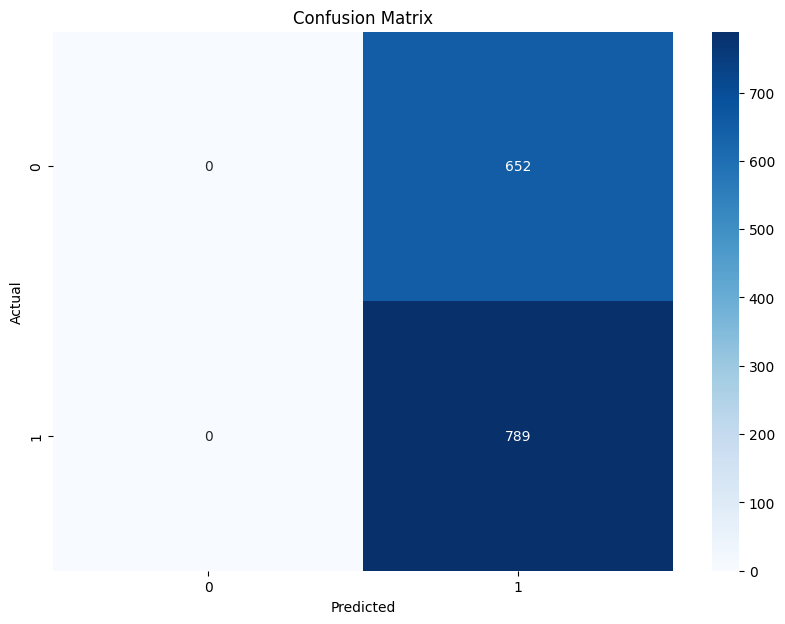

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import seaborn as sns

# Calculate metrics
conf_matrix = confusion_matrix(test_labels, test_labels_pred)
acc = accuracy_score(test_labels, test_labels_pred)
precision = precision_score(test_labels, test_labels_pred)
recall = recall_score(test_labels, test_labels_pred)
roc_auc = roc_auc_score(test_labels, test_predictions)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

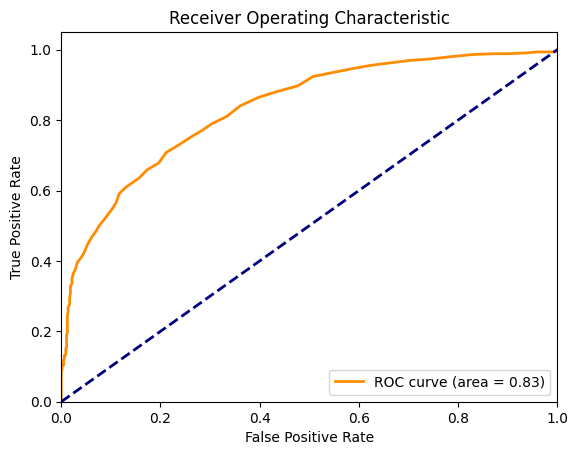

In [27]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(test_labels, test_predictions)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()